### 초기 경로 설정 (클래스 이용을 위함)

In [1]:
%cd /project/segmentation/smcho1201/segmentation_project

/project/segmentation/smcho1201/segmentation_project


In [2]:
# files and system
import os
import sys
import time
import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from IPython.display import clear_output
# working with images
import cv2
import imageio
import scipy.ndimage
# import skimage.transform

import torchvision.transforms as transforms

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F


import torchsummary
from tqdm import notebook

sys.path.insert(0, '..')

# losses
from utils.metrics import iou_pytorch_eval, IoULoss, IoUBCELoss, DiceBCELoss , dice_pytorch_eval
from utils.metrics import iou_pytorch_test, dice_pytorch_test, precision_pytorch_test, recall_pytorch_test, fbeta_pytorch_test, accuracy_pytorch_test

# dataset
from utils.dataset import myDataSet

## 랜덤성을 배제한 환경 고정

In [3]:
random_seed= 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

In [4]:
DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu") # select device for training, i.e. gpu or cpu
print(DEVICE)

cuda:1


# 1. Image augentation
> 실험할 때는 아예 augmentation도 고정시켜서 저장한 이미지를 사용해야 함.

In [5]:
_size = 224, 224
resize = transforms.Resize(_size, interpolation=0)

# set your transforms 
train_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                           transforms.RandomRotation(180),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(_size, padding = 10), # needed after rotation (with original size)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                       ])

/home/smcho1201/.conda/envs/pytorch/lib/python3.9/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


# 2. 데이터셋 클래스 생성
> 해당 클래스는 이용하려는 이미지와 라벨의 모든 경로(/data/segmentation/...)의 리스트를 인자로 받는다.   

In [6]:
train_images = glob.glob('/data/segmentation/breast-cancer/trainset_benign/images/*')
train_labels = glob.glob('/data/segmentation/breast-cancer/trainset_benign/labels/*')
train_images = [img for img in train_images if img.find('jpg')!= -1] # super pixels 이미지 제외

valid_images = glob.glob('/data/segmentation/breast-cancer/validationset_benign/images/*')
valid_labels = glob.glob('/data/segmentation/breast-cancer/validationset_benign/labels/*')
valid_images = [img for img in valid_images if img.find('jpg')!= -1] # super pixels 이미지 제외

train_images = sorted(train_images)
train_labels = sorted(train_labels)

valid_images = sorted(valid_images)
valid_labels = sorted(valid_labels)

# 데이터셋 클래스 적용
custom_dataset_train = myDataSet(train_images, train_labels, transforms=test_transforms)
print("My custom training-dataset has {} elements".format(len(custom_dataset_train)))

custom_dataset_val = myDataSet(valid_images, valid_labels, transforms=test_transforms)
print("My custom valing-dataset has {} elements".format(len(custom_dataset_val)))

My custom training-dataset has 261 elements
My custom valing-dataset has 88 elements


### dataset class check
> RGB 채널 평균 값이라 색 바뀜

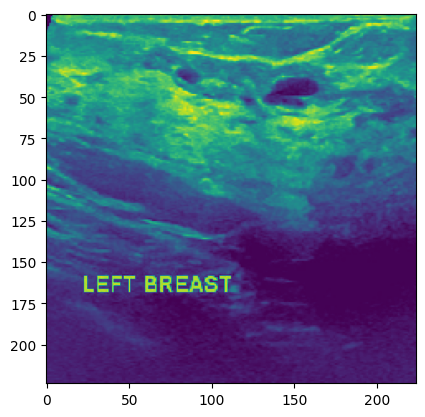

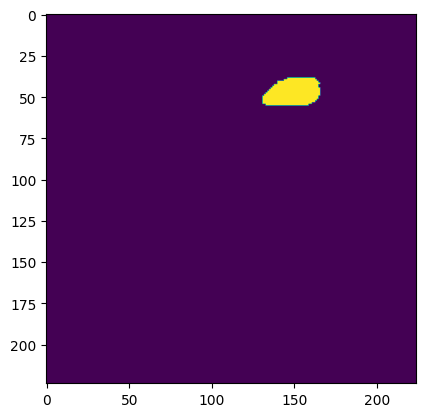

3픽셀의 평균값이라 색깔이 변경됨.


In [7]:
# Show example images.
image_number = 23
img, mask = custom_dataset_train.__getitem__(image_number)

# image
plt.figure()
plt.imshow(img.mean(0)) # 3 channels, take mean

# mask
plt.figure()
plt.imshow(mask[0, :, :]) # 1 channel, take it

plt.show()
print('3픽셀의 평균값이라 색깔이 변경됨.')

# 3. 모델 클래스 생성

In [6]:
# Begin training
from models.pop_seg_models.FCN.models.segmentation.fcn import fcn_resnet101

model = fcn_resnet101(num_classes = 1)
model = model.to(DEVICE) # load model to DEVICE

# 4. 하이퍼 파라미터 세팅 & 데이터 로더 생성

In [9]:
# Define variables for the training
epochs = 100
patience = 20
BATCH_SIZE = 8

dataloader_train = torch.utils.data.DataLoader(custom_dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
dataloader_val = torch.utils.data.DataLoader(custom_dataset_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [10]:
# Define optimiser and criterion for the training. You can try different ones to see which works best for your data and task
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-8)

criterion = DiceBCELoss()
model_name = 'FCN'
data_name = 'benign'

# 5. Training

 Epoch: 1 of 100, Iter.: 33 of 33, Train Loss: 1.266596, IoU: 0.267867, Dice: 0.370488
 Epoch: 1 of 100, Iter.: 33 of 33, Valid Loss: 0.977642, IoU: 0.374481, Dice: 0.477318

시각화되는 이미지는 1.실제 테스트 이미지 2.실제 라벨 이미지 3.예측 라벨 4.예측한 이미지 결과의 순서입니다.


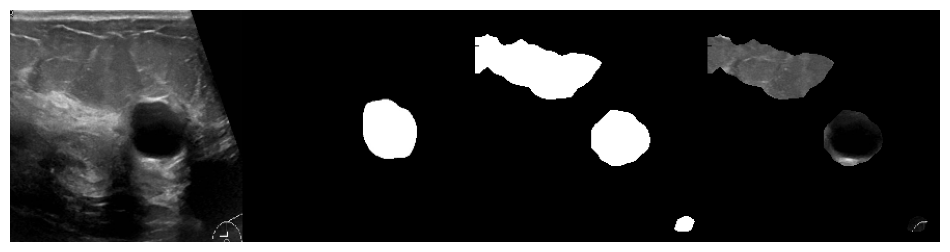

 Epoch: 2 of 100, Iter.: 33 of 33, Train Loss: 0.729514, IoU: 0.522640, Dice: 0.634529
 Epoch: 2 of 100, Iter.: 33 of 33, Valid Loss: 0.598489, IoU: 0.528374, Dice: 0.632976


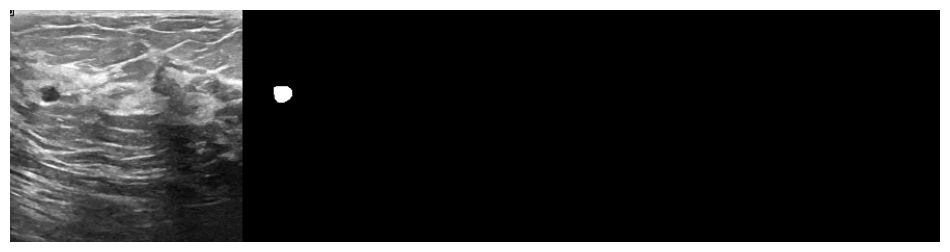

 Epoch: 3 of 100, Iter.: 33 of 33, Train Loss: 0.450879, IoU: 0.650987, Dice: 0.755151
 Epoch: 3 of 100, Iter.: 33 of 33, Valid Loss: 0.485574, IoU: 0.591351, Dice: 0.689085


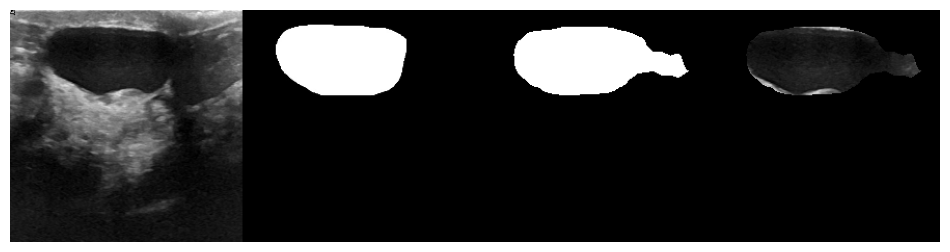

 Epoch: 4 of 100, Iter.: 33 of 33, Train Loss: 0.343359, IoU: 0.712088, Dice: 0.807703
 Epoch: 4 of 100, Iter.: 33 of 33, Valid Loss: 0.424992, IoU: 0.600397, Dice: 0.696868


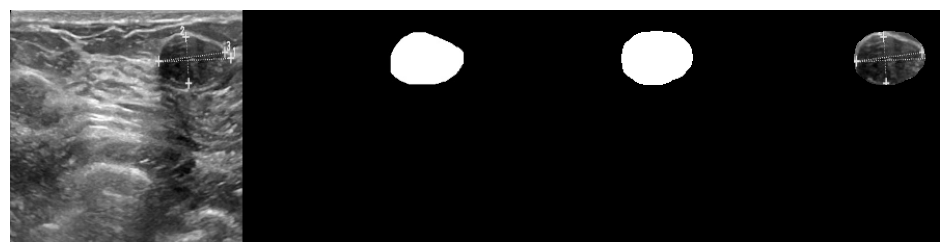

 Epoch: 5 of 100, Iter.: 33 of 33, Train Loss: 0.268190, IoU: 0.767590, Dice: 0.854042
 Epoch: 5 of 100, Iter.: 33 of 33, Valid Loss: 0.385338, IoU: 0.644838, Dice: 0.742393


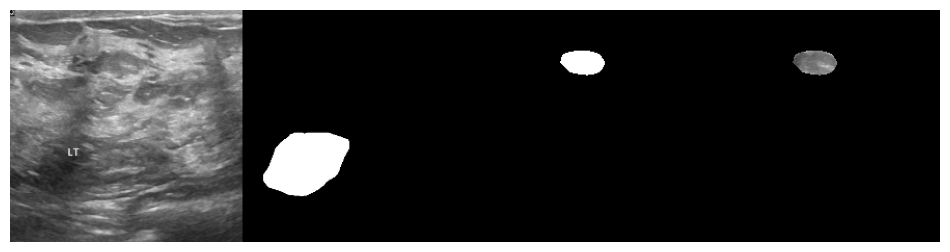

 Epoch: 6 of 100, Iter.: 33 of 33, Train Loss: 0.252275, IoU: 0.760882, Dice: 0.849147
 Epoch: 6 of 100, Iter.: 33 of 33, Valid Loss: 0.344595, IoU: 0.641902, Dice: 0.739881


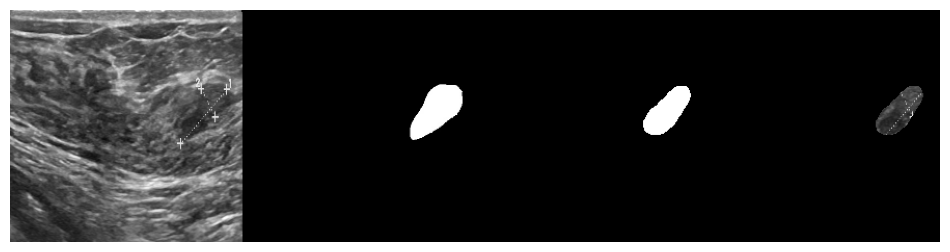

 Epoch: 7 of 100, Iter.: 33 of 33, Train Loss: 0.206055, IoU: 0.779266, Dice: 0.859805
 Epoch: 7 of 100, Iter.: 33 of 33, Valid Loss: 0.340973, IoU: 0.611703, Dice: 0.708441


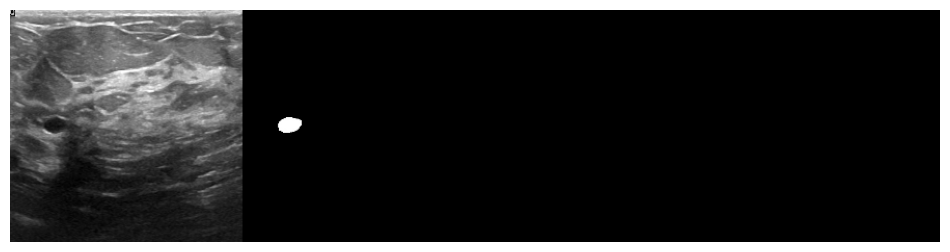

 Epoch: 8 of 100, Iter.: 33 of 33, Train Loss: 0.161294, IoU: 0.813617, Dice: 0.887089
 Epoch: 8 of 100, Iter.: 33 of 33, Valid Loss: 0.328200, IoU: 0.659013, Dice: 0.750946


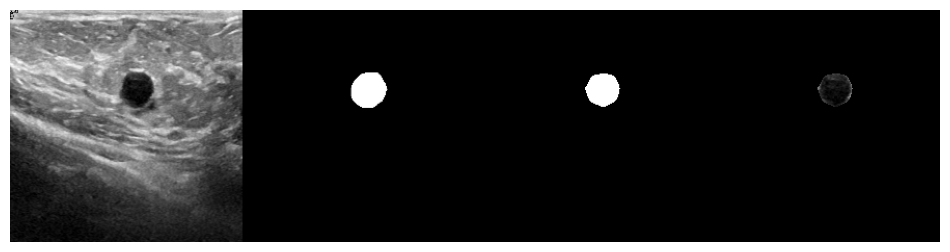

 Epoch: 9 of 100, Iter.: 33 of 33, Train Loss: 0.150718, IoU: 0.825471, Dice: 0.896524
 Epoch: 9 of 100, Iter.: 33 of 33, Valid Loss: 0.317667, IoU: 0.676375, Dice: 0.770050


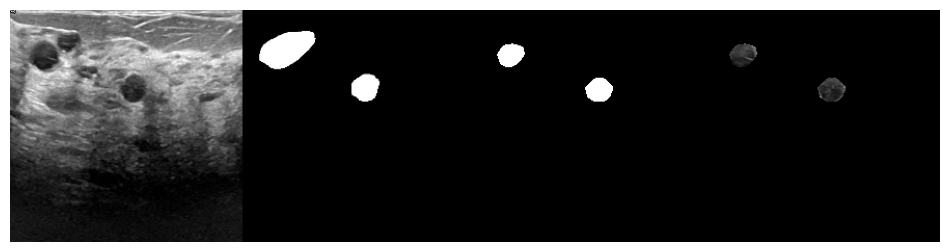

 Epoch: 10 of 100, Iter.: 33 of 33, Train Loss: 0.129589, IoU: 0.836407, Dice: 0.902454
 Epoch: 10 of 100, Iter.: 33 of 33, Valid Loss: 0.310363, IoU: 0.692838, Dice: 0.784974


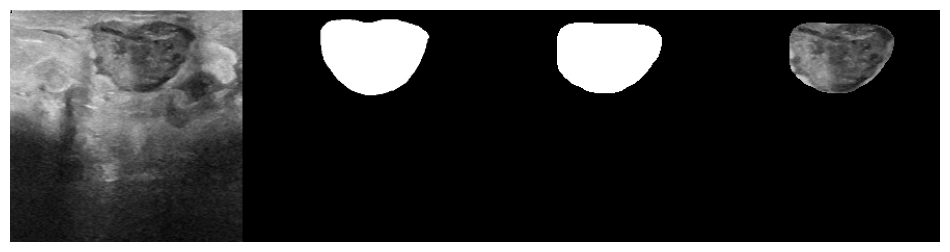

 Epoch: 11 of 100, Iter.: 33 of 33, Train Loss: 0.107560, IoU: 0.865219, Dice: 0.925160
 Epoch: 11 of 100, Iter.: 33 of 33, Valid Loss: 0.292050, IoU: 0.698412, Dice: 0.785243


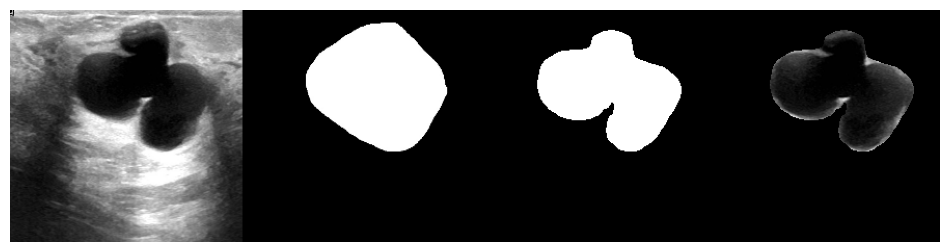

 Epoch: 12 of 100, Iter.: 33 of 33, Train Loss: 0.103325, IoU: 0.867960, Dice: 0.926107
 Epoch: 12 of 100, Iter.: 33 of 33, Valid Loss: 0.320937, IoU: 0.690122, Dice: 0.775564


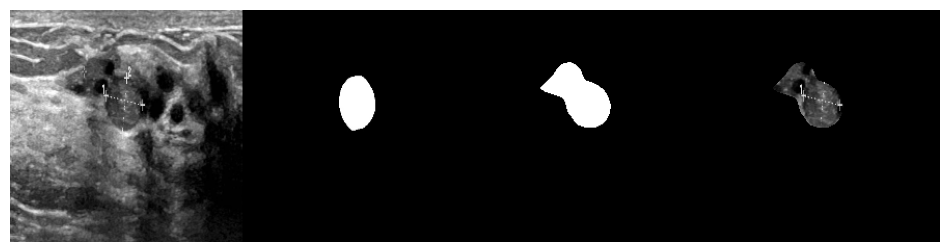

 Epoch: 13 of 100, Iter.: 33 of 33, Train Loss: 0.094029, IoU: 0.875460, Dice: 0.929388
 Epoch: 13 of 100, Iter.: 33 of 33, Valid Loss: 0.303644, IoU: 0.677513, Dice: 0.765347


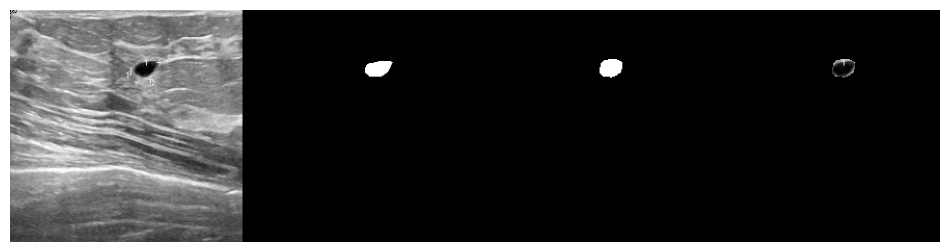

 Epoch: 14 of 100, Iter.: 33 of 33, Train Loss: 0.086705, IoU: 0.877335, Dice: 0.928395
 Epoch: 14 of 100, Iter.: 33 of 33, Valid Loss: 0.302097, IoU: 0.682491, Dice: 0.773021


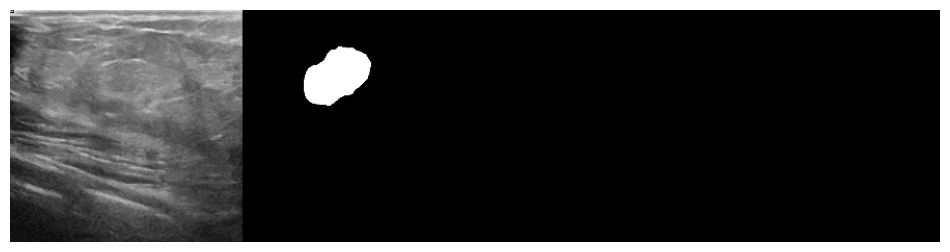

 Epoch: 15 of 100, Iter.: 33 of 33, Train Loss: 0.083549, IoU: 0.882193, Dice: 0.934069
 Epoch: 15 of 100, Iter.: 33 of 33, Valid Loss: 0.292945, IoU: 0.691702, Dice: 0.781885


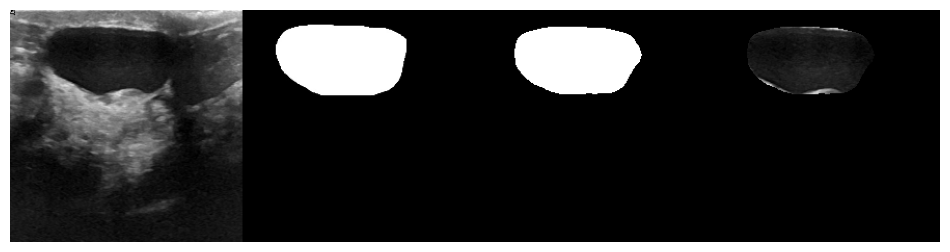

 Epoch: 16 of 100, Iter.: 33 of 33, Train Loss: 0.076938, IoU: 0.890094, Dice: 0.938609
 Epoch: 16 of 100, Iter.: 33 of 33, Valid Loss: 0.275600, IoU: 0.705705, Dice: 0.790309


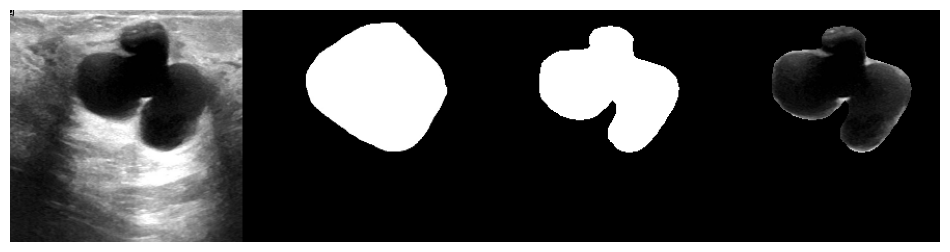

 Epoch: 17 of 100, Iter.: 33 of 33, Train Loss: 0.067912, IoU: 0.900250, Dice: 0.945126
 Epoch: 17 of 100, Iter.: 33 of 33, Valid Loss: 0.284386, IoU: 0.677560, Dice: 0.767030


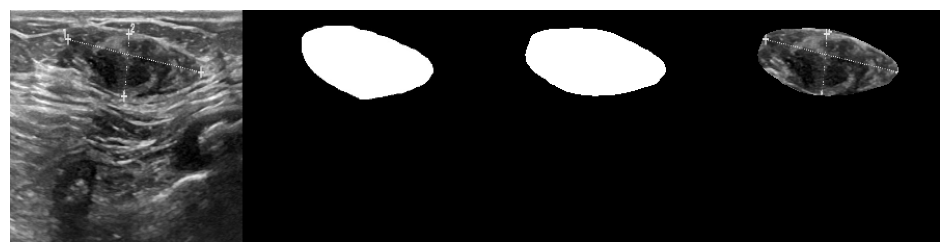

 Epoch: 18 of 100, Iter.: 33 of 33, Train Loss: 0.066893, IoU: 0.900525, Dice: 0.945827
 Epoch: 18 of 100, Iter.: 33 of 33, Valid Loss: 0.282074, IoU: 0.696174, Dice: 0.786295


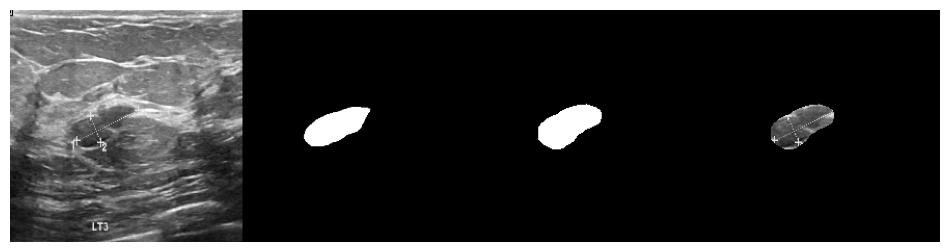

 Epoch: 19 of 100, Iter.: 33 of 33, Train Loss: 0.057468, IoU: 0.909846, Dice: 0.951566
 Epoch: 19 of 100, Iter.: 33 of 33, Valid Loss: 0.282079, IoU: 0.725344, Dice: 0.805646


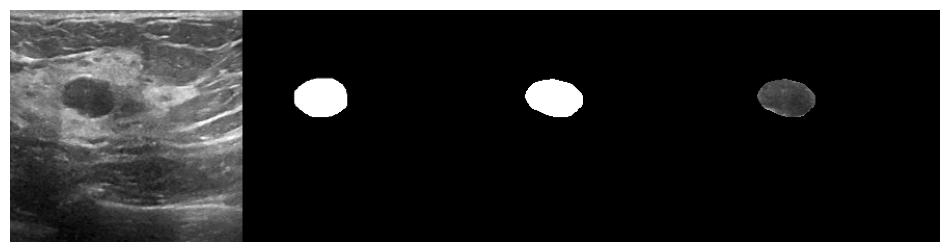

 Epoch: 20 of 100, Iter.: 33 of 33, Train Loss: 0.054440, IoU: 0.918234, Dice: 0.956396
 Epoch: 20 of 100, Iter.: 33 of 33, Valid Loss: 0.289971, IoU: 0.701671, Dice: 0.787310


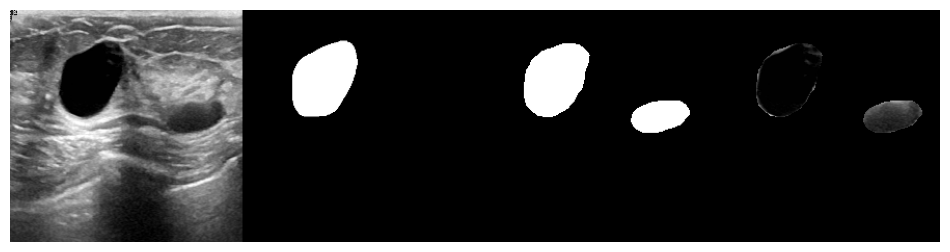

 Epoch: 21 of 100, Iter.: 33 of 33, Train Loss: 0.056876, IoU: 0.920065, Dice: 0.957574
 Epoch: 21 of 100, Iter.: 33 of 33, Valid Loss: 0.285795, IoU: 0.697749, Dice: 0.782409


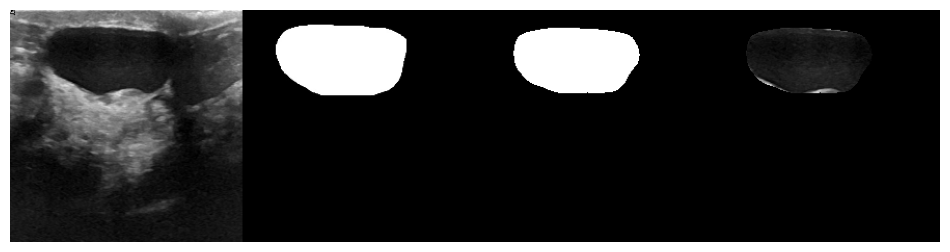

 Epoch: 22 of 100, Iter.: 33 of 33, Train Loss: 0.051496, IoU: 0.920035, Dice: 0.957524
 Epoch: 22 of 100, Iter.: 33 of 33, Valid Loss: 0.292184, IoU: 0.710949, Dice: 0.798057


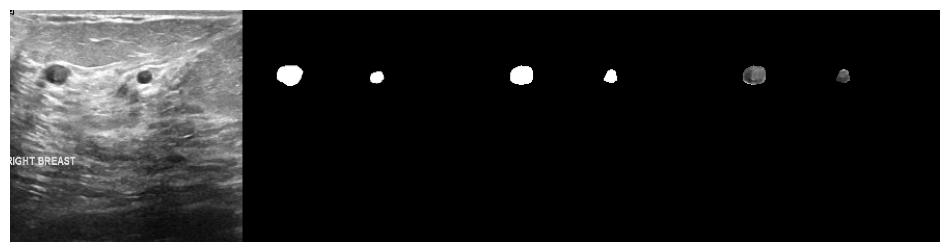

 Epoch: 23 of 100, Iter.: 33 of 33, Train Loss: 0.051485, IoU: 0.920982, Dice: 0.957446
 Epoch: 23 of 100, Iter.: 33 of 33, Valid Loss: 0.284070, IoU: 0.707598, Dice: 0.792547


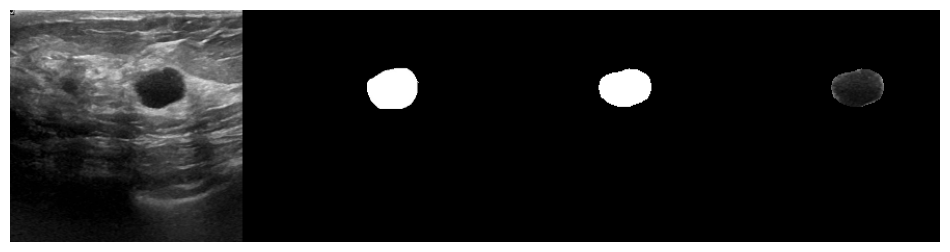

 Epoch: 24 of 100, Iter.: 33 of 33, Train Loss: 0.049649, IoU: 0.925446, Dice: 0.960305
 Epoch: 24 of 100, Iter.: 33 of 33, Valid Loss: 0.274346, IoU: 0.710918, Dice: 0.796810


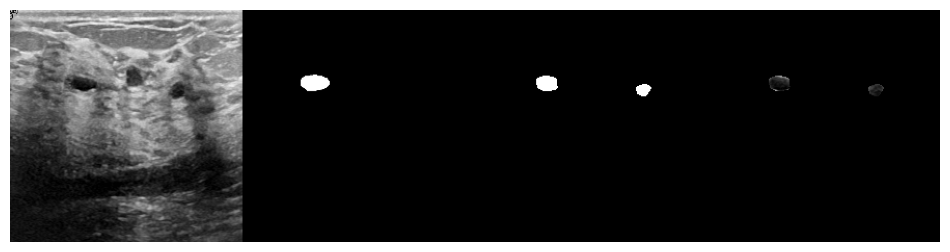

 Epoch: 25 of 100, Iter.: 33 of 33, Train Loss: 0.045787, IoU: 0.927475, Dice: 0.961678
 Epoch: 25 of 100, Iter.: 33 of 33, Valid Loss: 0.280664, IoU: 0.706434, Dice: 0.789836


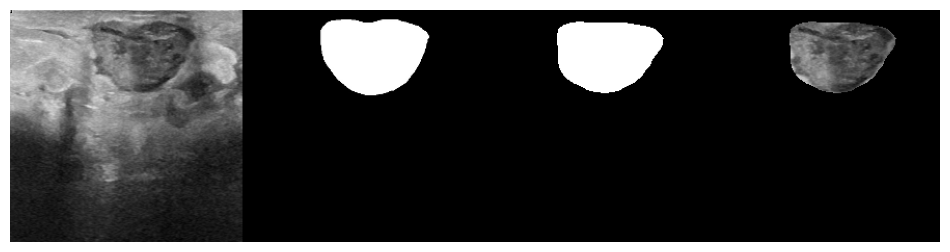

 Epoch: 26 of 100, Iter.: 33 of 33, Train Loss: 0.046157, IoU: 0.929740, Dice: 0.962997
 Epoch: 26 of 100, Iter.: 33 of 33, Valid Loss: 0.270827, IoU: 0.718037, Dice: 0.800880


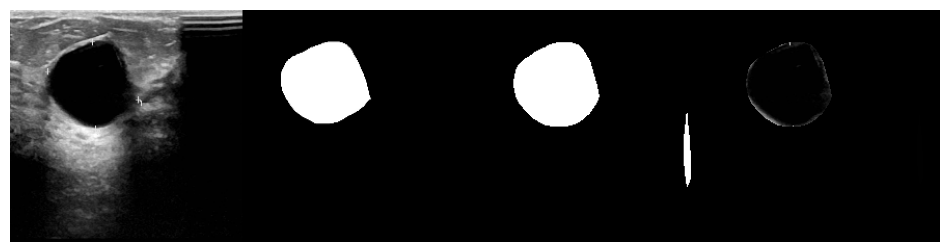

 Epoch: 27 of 100, Iter.: 33 of 33, Train Loss: 0.045754, IoU: 0.927571, Dice: 0.961705
 Epoch: 27 of 100, Iter.: 33 of 33, Valid Loss: 0.281917, IoU: 0.714827, Dice: 0.800654


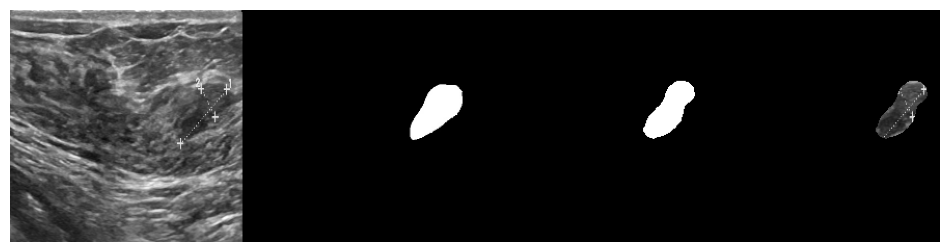

 Epoch: 28 of 100, Iter.: 33 of 33, Train Loss: 0.043023, IoU: 0.931599, Dice: 0.963924
 Epoch: 28 of 100, Iter.: 33 of 33, Valid Loss: 0.289006, IoU: 0.710523, Dice: 0.798022


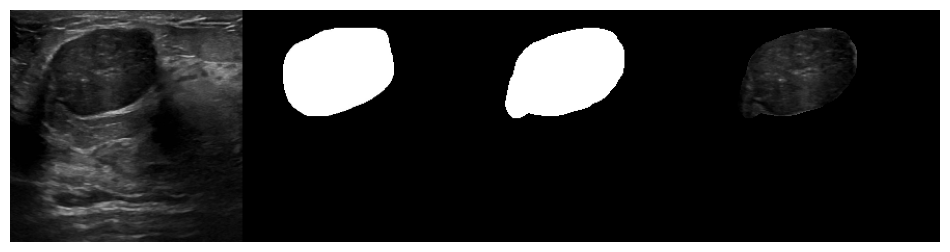

 Epoch: 29 of 100, Iter.: 33 of 33, Train Loss: 0.039484, IoU: 0.937775, Dice: 0.967399
 Epoch: 29 of 100, Iter.: 33 of 33, Valid Loss: 0.276953, IoU: 0.721810, Dice: 0.806503


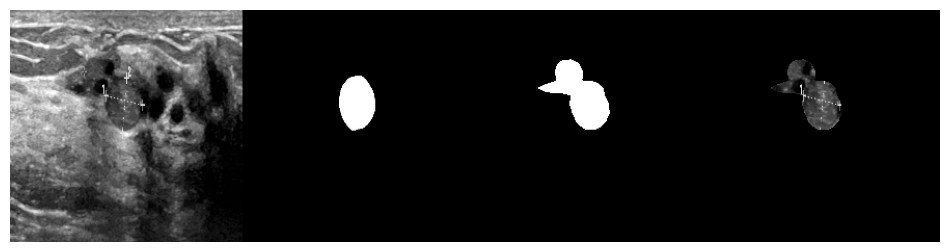

 Epoch: 30 of 100, Iter.: 33 of 33, Train Loss: 0.038153, IoU: 0.939640, Dice: 0.968447
 Epoch: 30 of 100, Iter.: 33 of 33, Valid Loss: 0.292833, IoU: 0.715386, Dice: 0.799860


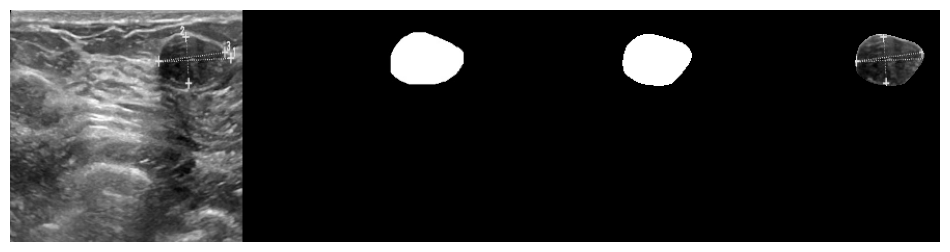

 Epoch: 31 of 100, Iter.: 33 of 33, Train Loss: 0.036661, IoU: 0.940353, Dice: 0.968850
 Epoch: 31 of 100, Iter.: 33 of 33, Valid Loss: 0.302551, IoU: 0.702060, Dice: 0.789926


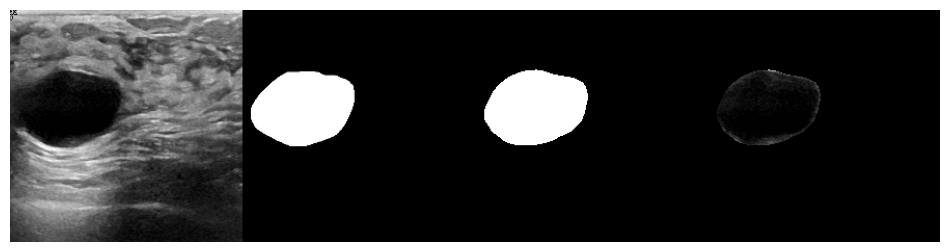

 Epoch: 32 of 100, Iter.: 33 of 33, Train Loss: 0.036265, IoU: 0.941628, Dice: 0.969522
 Epoch: 32 of 100, Iter.: 33 of 33, Valid Loss: 0.298494, IoU: 0.724022, Dice: 0.805403


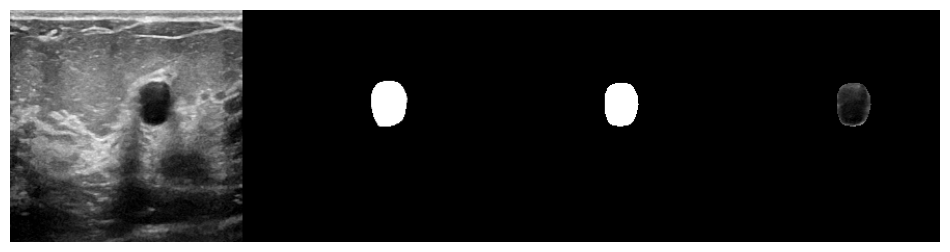

 Epoch: 33 of 100, Iter.: 33 of 33, Train Loss: 0.035986, IoU: 0.942276, Dice: 0.969885
 Epoch: 33 of 100, Iter.: 33 of 33, Valid Loss: 0.316540, IoU: 0.708000, Dice: 0.794327


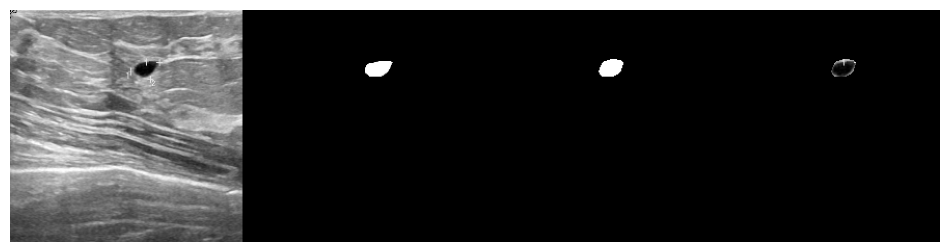

 Epoch: 34 of 100, Iter.: 33 of 33, Train Loss: 0.035719, IoU: 0.941774, Dice: 0.969607
 Epoch: 34 of 100, Iter.: 33 of 33, Valid Loss: 0.305170, IoU: 0.713122, Dice: 0.797588


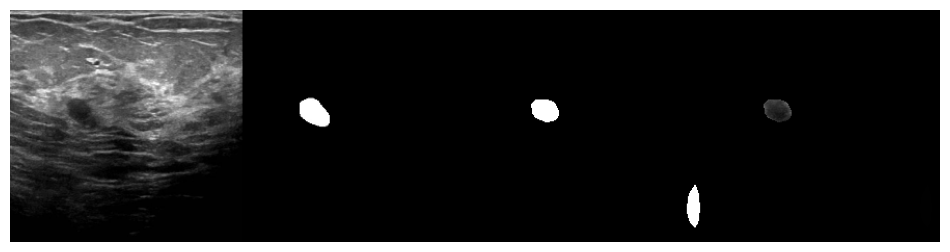

 Epoch: 35 of 100, Iter.: 33 of 33, Train Loss: 0.035598, IoU: 0.941544, Dice: 0.969502
 Epoch: 35 of 100, Iter.: 33 of 33, Valid Loss: 0.305616, IoU: 0.696242, Dice: 0.781926


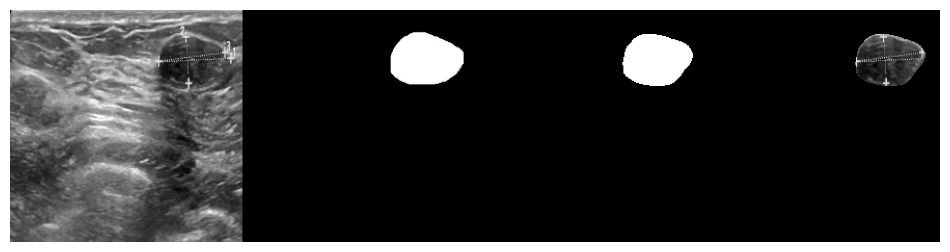

 Epoch: 36 of 100, Iter.: 33 of 33, Train Loss: 0.035573, IoU: 0.943203, Dice: 0.970330
 Epoch: 36 of 100, Iter.: 33 of 33, Valid Loss: 0.300443, IoU: 0.724489, Dice: 0.805560


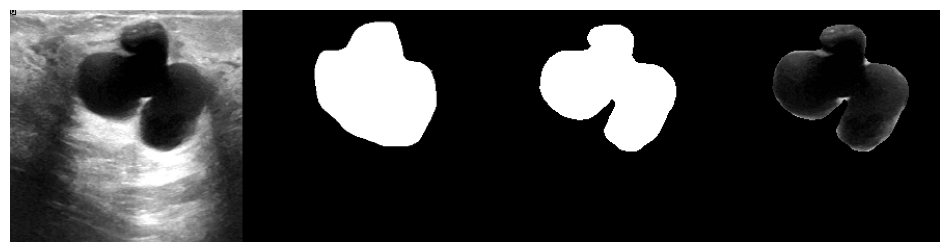

 Epoch: 37 of 100, Iter.: 33 of 33, Train Loss: 0.034626, IoU: 0.942904, Dice: 0.970133
 Epoch: 37 of 100, Iter.: 33 of 33, Valid Loss: 0.297159, IoU: 0.729598, Dice: 0.808759


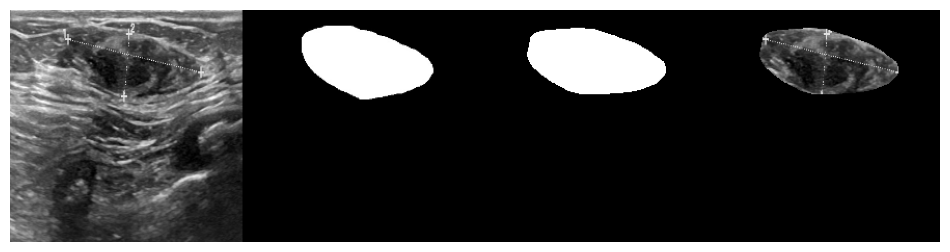

 Epoch: 38 of 100, Iter.: 33 of 33, Train Loss: 0.033354, IoU: 0.945485, Dice: 0.971580
 Epoch: 38 of 100, Iter.: 33 of 33, Valid Loss: 0.297507, IoU: 0.717645, Dice: 0.799869


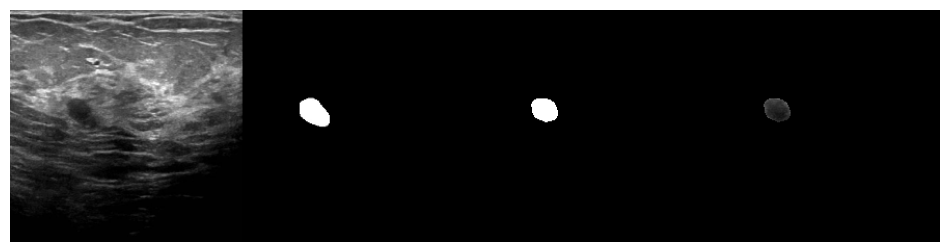

 Epoch: 39 of 100, Iter.: 33 of 33, Train Loss: 0.030690, IoU: 0.947711, Dice: 0.972787
 Epoch: 39 of 100, Iter.: 33 of 33, Valid Loss: 0.304903, IoU: 0.719054, Dice: 0.800286


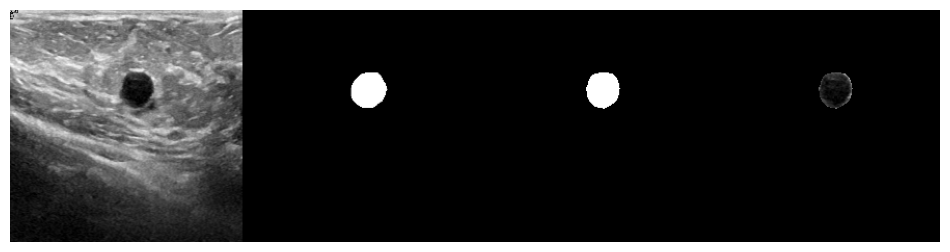

 Epoch: 40 of 100, Iter.: 33 of 33, Train Loss: 0.031273, IoU: 0.947325, Dice: 0.972563
 Epoch: 40 of 100, Iter.: 33 of 33, Valid Loss: 0.300542, IoU: 0.710540, Dice: 0.794683


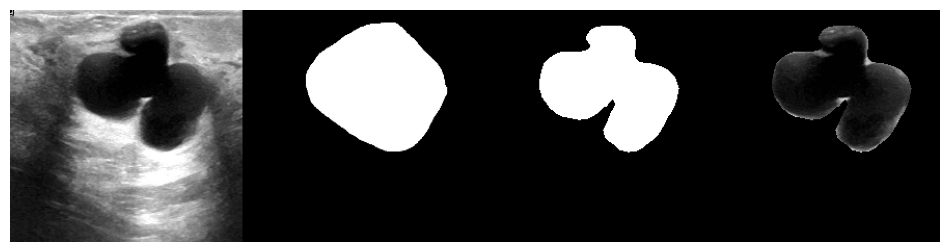

 Epoch: 41 of 100, Iter.: 33 of 33, Train Loss: 0.030572, IoU: 0.948393, Dice: 0.973247
 Epoch: 41 of 100, Iter.: 33 of 33, Valid Loss: 0.298707, IoU: 0.723256, Dice: 0.804810


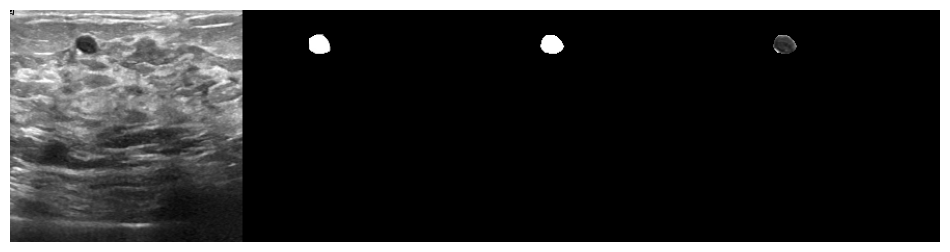

 Epoch: 42 of 100, Iter.: 33 of 33, Train Loss: 0.029159, IoU: 0.952730, Dice: 0.975519
 Epoch: 42 of 100, Iter.: 33 of 33, Valid Loss: 0.319411, IoU: 0.720813, Dice: 0.803134


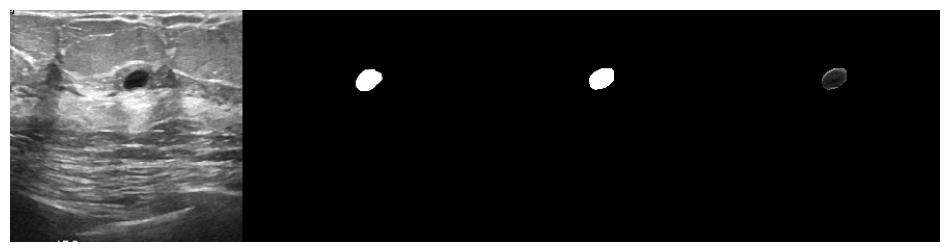

 Epoch: 43 of 100, Iter.: 33 of 33, Train Loss: 0.029979, IoU: 0.948942, Dice: 0.973304
 Epoch: 43 of 100, Iter.: 33 of 33, Valid Loss: 0.327156, IoU: 0.719631, Dice: 0.802906


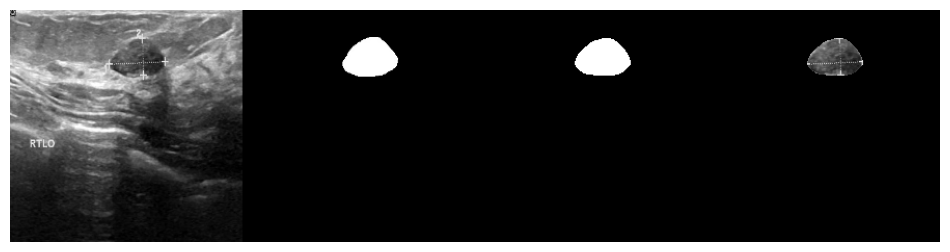

 Epoch: 44 of 100, Iter.: 33 of 33, Train Loss: 0.030796, IoU: 0.947045, Dice: 0.972390
 Epoch: 44 of 100, Iter.: 33 of 33, Valid Loss: 0.354257, IoU: 0.707892, Dice: 0.792220


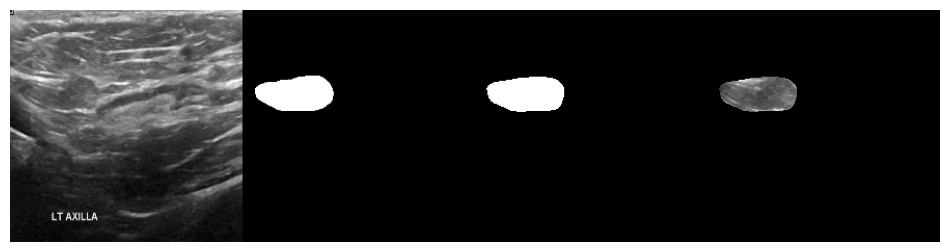

 Epoch: 45 of 100, Iter.: 33 of 33, Train Loss: 0.029303, IoU: 0.943532, Dice: 0.970201
 Epoch: 45 of 100, Iter.: 33 of 33, Valid Loss: 0.344745, IoU: 0.713607, Dice: 0.794523


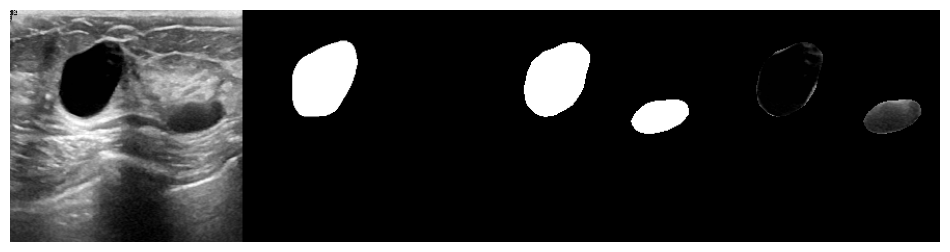

 Epoch: 46 of 100, Iter.: 33 of 33, Train Loss: 0.028459, IoU: 0.950232, Dice: 0.974158
 Epoch: 46 of 100, Iter.: 33 of 33, Valid Loss: 0.361662, IoU: 0.708594, Dice: 0.793489


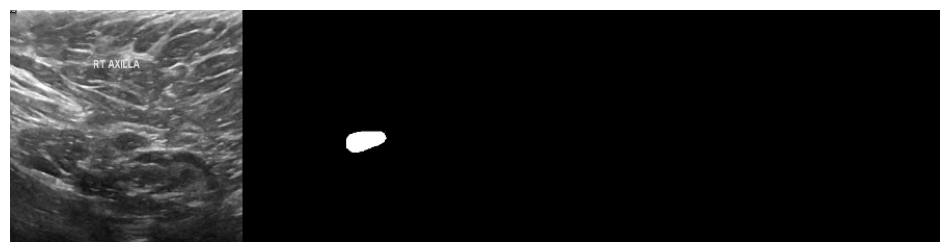

 Epoch: 47 of 100, Iter.: 33 of 33, Train Loss: 0.027893, IoU: 0.952943, Dice: 0.975659
 Epoch: 47 of 100, Iter.: 33 of 33, Valid Loss: 0.336404, IoU: 0.720475, Dice: 0.800533


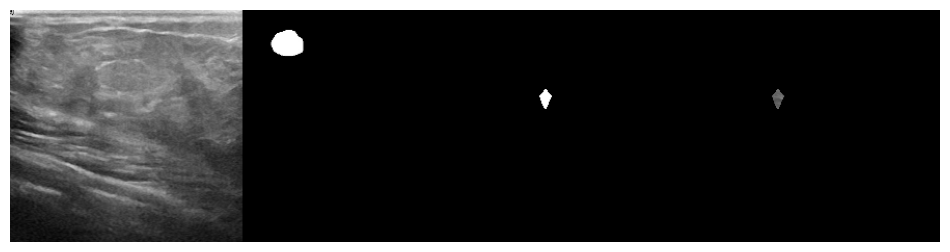

 Epoch: 48 of 100, Iter.: 33 of 33, Train Loss: 0.026197, IoU: 0.954234, Dice: 0.976353
 Epoch: 48 of 100, Iter.: 33 of 33, Valid Loss: 0.345666, IoU: 0.722233, Dice: 0.801338


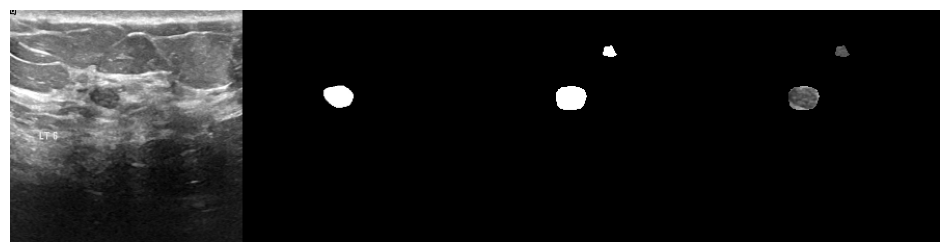

 Epoch: 49 of 100, Iter.: 33 of 33, Train Loss: 0.026012, IoU: 0.955589, Dice: 0.977028
 Epoch: 49 of 100, Iter.: 33 of 33, Valid Loss: 0.341420, IoU: 0.717669, Dice: 0.799748


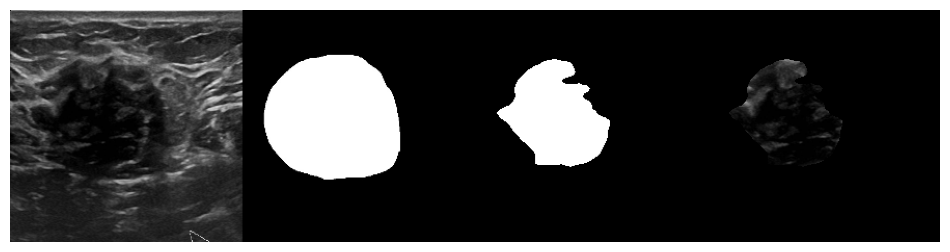

 Epoch: 50 of 100, Iter.: 33 of 33, Train Loss: 0.025131, IoU: 0.956922, Dice: 0.977753
 Epoch: 50 of 100, Iter.: 33 of 33, Valid Loss: 0.356906, IoU: 0.717719, Dice: 0.798986


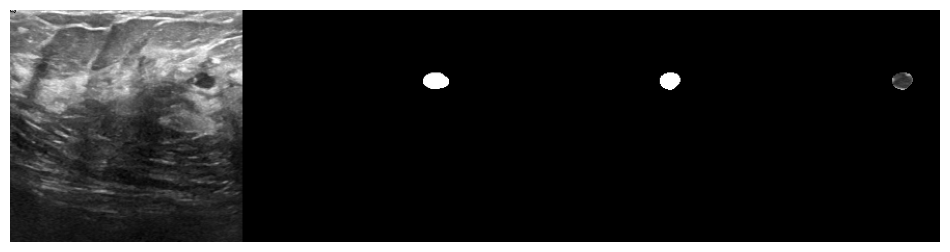

 Epoch: 51 of 100, Iter.: 33 of 33, Train Loss: 0.025248, IoU: 0.960841, Dice: 0.979852
 Epoch: 51 of 100, Iter.: 33 of 33, Valid Loss: 0.353120, IoU: 0.721709, Dice: 0.802790


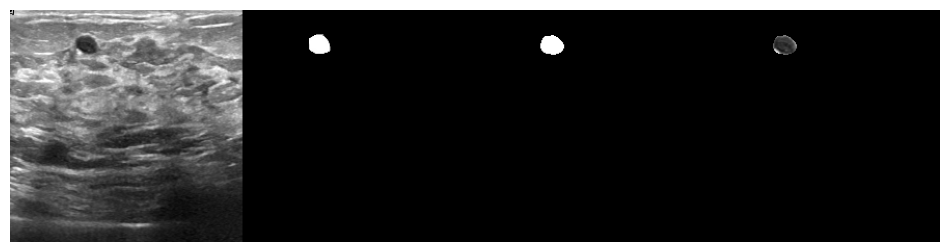

 Epoch: 52 of 100, Iter.: 33 of 33, Train Loss: 0.025379, IoU: 0.956014, Dice: 0.977215
 Epoch: 52 of 100, Iter.: 33 of 33, Valid Loss: 0.355262, IoU: 0.713140, Dice: 0.796733


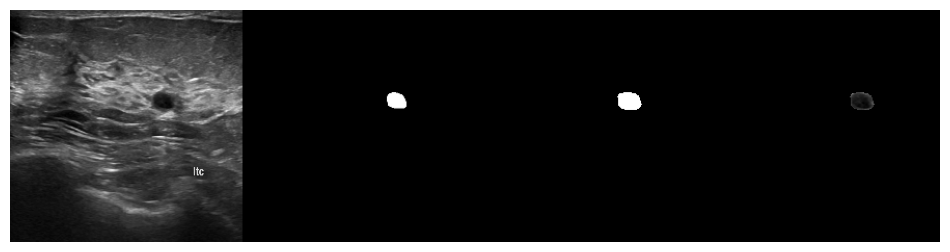

 Epoch: 53 of 100, Iter.: 33 of 33, Train Loss: 0.024071, IoU: 0.956756, Dice: 0.977684
 Epoch: 53 of 100, Iter.: 33 of 33, Valid Loss: 0.353713, IoU: 0.710443, Dice: 0.795093


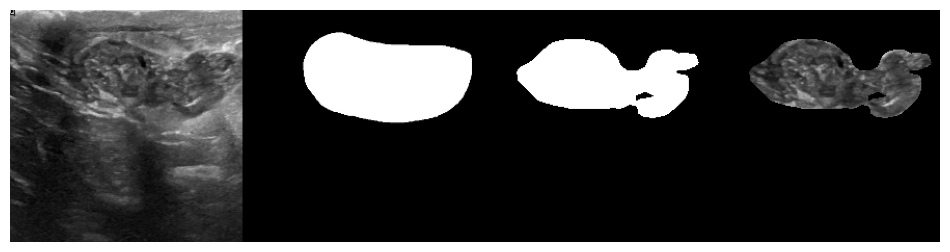

 Epoch: 54 of 100, Iter.: 33 of 33, Train Loss: 0.024089, IoU: 0.957530, Dice: 0.978073
 Epoch: 54 of 100, Iter.: 33 of 33, Valid Loss: 0.376704, IoU: 0.711699, Dice: 0.795795


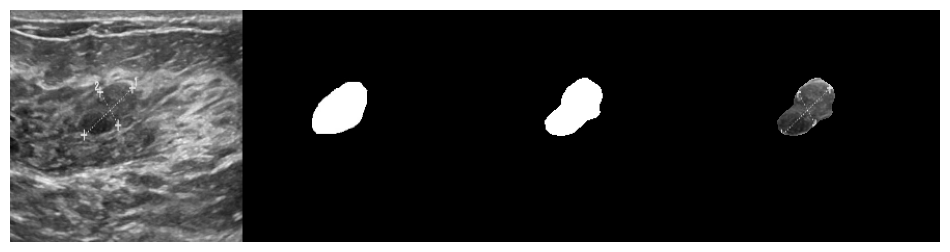

 Epoch: 55 of 100, Iter.: 33 of 33, Train Loss: 0.022815, IoU: 0.960569, Dice: 0.979691
 Epoch: 55 of 100, Iter.: 33 of 33, Valid Loss: 0.341162, IoU: 0.708289, Dice: 0.792992


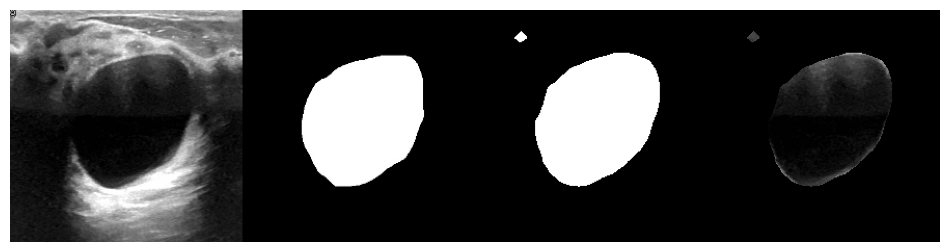

 Epoch: 56 of 100, Iter.: 33 of 33, Train Loss: 0.023750, IoU: 0.958923, Dice: 0.978812
 Epoch: 56 of 100, Iter.: 33 of 33, Valid Loss: 0.345944, IoU: 0.724780, Dice: 0.805432


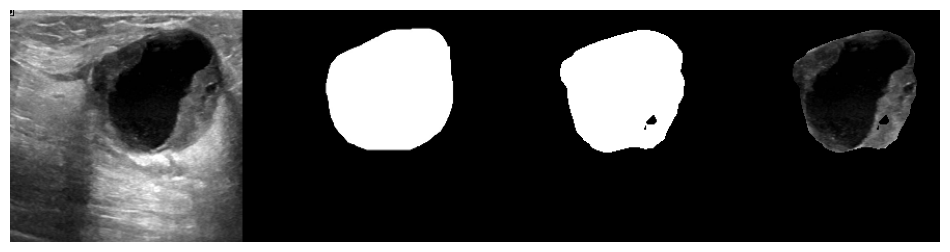

 Epoch: 57 of 100, Iter.: 33 of 33, Train Loss: 0.023335, IoU: 0.959654, Dice: 0.979191
 Epoch: 57 of 100, Iter.: 33 of 33, Valid Loss: 0.353071, IoU: 0.726962, Dice: 0.806761


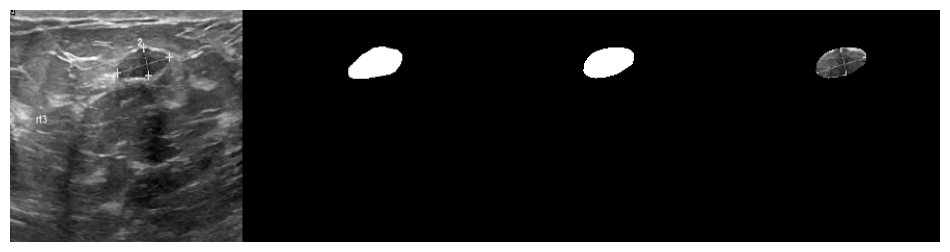

 Epoch: 58 of 100, Iter.: 33 of 33, Train Loss: 0.023861, IoU: 0.957465, Dice: 0.978062
 Epoch: 58 of 100, Iter.: 33 of 33, Valid Loss: 0.353058, IoU: 0.725456, Dice: 0.805725


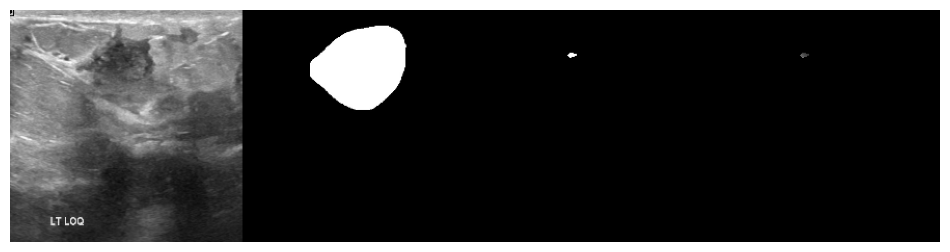


Early stopping. Target criteria has not improved for 20 epochs.

CPU times: user 9min 25s, sys: 7min 52s, total: 17min 17s
Wall time: 12min 54s


In [11]:

%%time
from ploting import plot_model_prediction

train_losses, val_losses = [], []
train_ious, val_ious = [], []
train_dices, val_dices = [], []
best_iou, best_dice, best_loss = 0, 0, np.inf
best_epoch_dice = -1
state = {}
lst_epoch_metric = []

start_time = time.time()
for epoch in range(1, epochs+1):
    running_loss, running_iou, running_dice = 0, 0, 0

    # Train
    model.train()
    for i, (imgs, masks) in enumerate(dataloader_train):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        
        optimizer.zero_grad()
        loss = criterion(prediction, masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_iou += iou_pytorch_eval(prediction, masks)
        running_dice += dice_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, IoU:  {:.6f},  Dice:  {:.6f}".format(epoch, epochs, i, len(dataloader_train), running_loss/(i+1), running_iou/(i+1), running_dice/(i+1)), end="")
        
    # Validate
    model.eval()
    val_loss, val_iou, val_dice = 0, 0, 0
    for i, (imgs, masks) in enumerate(dataloader_val):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        loss = criterion(prediction, masks)
        val_loss += loss.item()
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, Val. Loss: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_loss/len(dataloader_train), val_loss/(i+1)), end="")
        
        val_iou += iou_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, IoU: {:.6f}, Val. IoU: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_iou/len(dataloader_train), val_iou/(i+1)), end="")

        val_dice += dice_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, Dice: {:.6f}, Val. Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_dice/len(dataloader_train), val_dice/(i+1)), end="")
    
    
    # compute overall epoch losses
    epoch_train_loss = running_loss/len(dataloader_train)
    train_losses.append(epoch_train_loss)
    epoch_val_loss = val_loss/len(dataloader_val)
    val_losses.append(epoch_val_loss)

    # compute overall epoch iou-s
    epoch_train_iou = (running_iou/len(dataloader_train)).item()
    train_ious.append(epoch_train_iou)
    epoch_val_iou = (val_iou/len(dataloader_val)).item()
    val_ious.append(epoch_val_iou)
    
    # compute overall epoch dice
    epoch_train_dice = (running_dice/len(dataloader_train)).item()
    train_dices.append(epoch_train_dice)
    epoch_val_dice = (val_dice/len(dataloader_val)).item()
    val_dices.append(epoch_val_dice)

    print("\r Epoch: {} of {}, Iter.: {} of {}, Train Loss: {:.6f}, IoU: {:.6f}, Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_train_loss, epoch_train_iou, epoch_train_dice))
    print("\r Epoch: {} of {}, Iter.: {} of {}, Valid Loss: {:.6f}, IoU: {:.6f}, Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_val_loss, epoch_val_iou, epoch_val_dice))
    if epoch == 1:
        print('\n시각화되는 이미지는 1.실제 테스트 이미지 2.실제 라벨 이미지 3.예측 라벨 4.예측한 이미지 결과의 순서입니다.')
    plot_model_prediction(model, DEVICE, valid_images, valid_labels)
        
    # plot
    metrics = {'loss':[train_losses, epoch_train_loss, val_losses, epoch_val_loss],
               'Iou':[train_ious, epoch_train_iou, val_ious,  epoch_val_iou],
               'Dice':[train_dices, epoch_train_dice, val_dices,  epoch_val_dice]}
    
    lst_epoch_metric.append([round(epoch_train_loss,4), round(epoch_train_iou,4), round(epoch_train_dice,4), 
                             round(epoch_val_loss,4), round(epoch_val_iou,4), round(epoch_val_dice,4)]) 

    # save if best results or break is has not improved for {patience} number of epochs
    best_iou = max(best_iou, epoch_val_iou)
    best_dice = max(best_dice, epoch_val_dice)
    best_loss = min(best_loss, epoch_val_loss)
    best_epoch_dice = epoch if best_dice == epoch_val_dice else best_epoch_dice

    # record losses
    state['train_losses'] = train_losses
    state['val_losses'] = val_losses
    
    if best_epoch_dice == epoch:
        # print('Saving..')
        state['net'] = model.state_dict()
        state['dice'] = best_dice
        state['epoch'] = epoch
            
        if not os.path.isdir('checkpoints'):
            os.mkdir('checkpoints')
        torch.save(state, f'./checkpoints/ckpt_{model_name}_{data_name}.pth')
    
    
    elif best_epoch_dice + patience < epoch:
        print(f"\nEarly stopping. Target criteria has not improved for {patience} epochs.\n")
        break

file_name = f'{model_name}_{data_name}'
# load once more and write all the losses down (othw can miss the last 10)
end_time = time.time() - start_time

state = torch.load(f'./checkpoints/ckpt_{model_name}_{data_name}.pth')
state['train_losses'] = train_losses
state['val_losses'] = val_losses
torch.save(state, f'./checkpoints/ckpt_{model_name}_{data_name}.pth')

df_epoch_metric = pd.DataFrame(lst_epoch_metric, columns = ['epoch_train_loss', 'epoch_train_iou', 'epoch_train_dice', 'epoch_val_loss', 'epoch_val_iou', 'epoch_val_dice'])
df_epoch_metric.to_csv(f'/project/segmentation/smcho1201/training_{model_name}/csv_{file_name}.csv', index_label = ['epoch'])

Validationset 기준 
Best_epoch:37, Best_IOU:0.7296, Best_DiceScore:0.8088


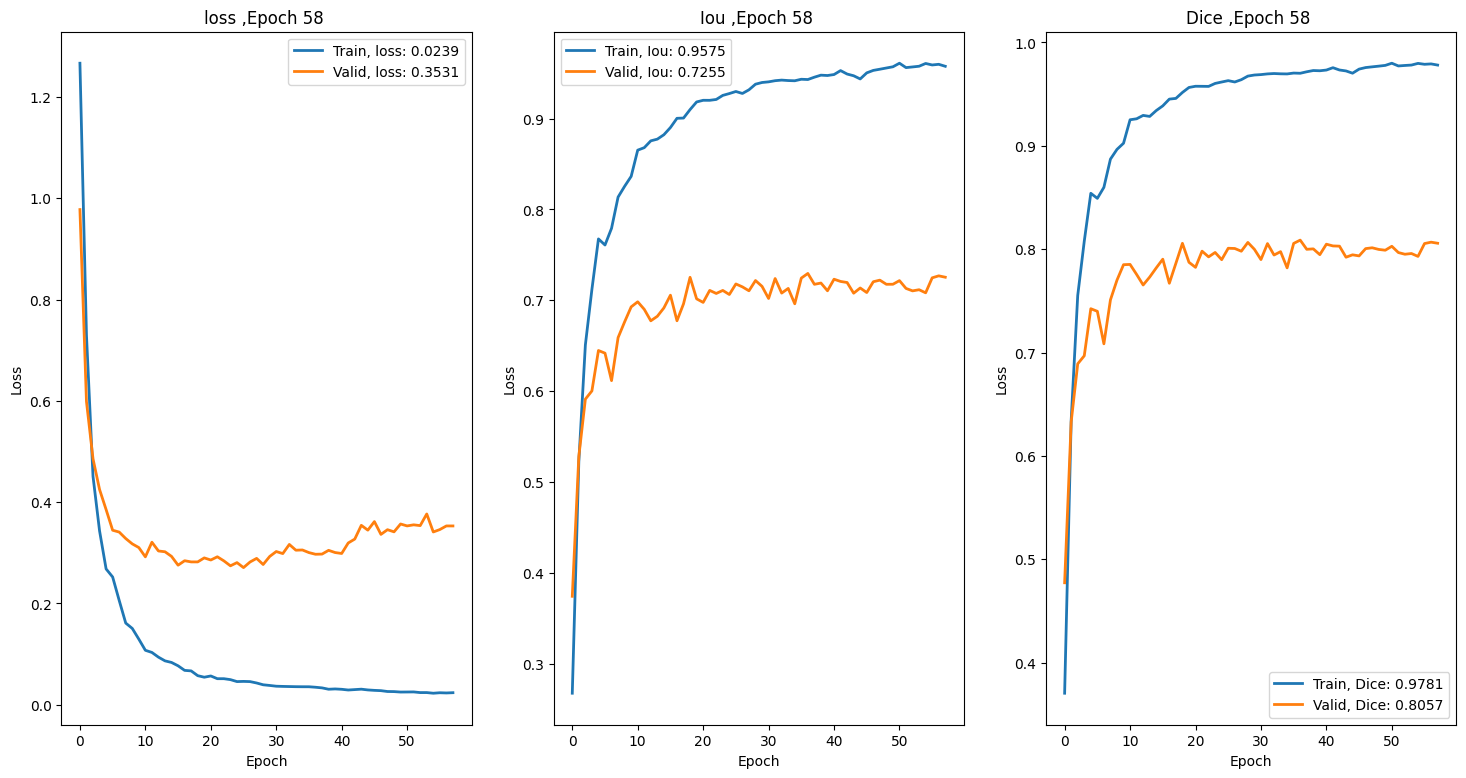

In [12]:
print(f'Validationset 기준 \nBest_epoch:{best_epoch_dice}, Best_IOU:{best_iou:.4f}, Best_DiceScore:{best_dice:.4f}')

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 9))           
for i, (metric, value) in enumerate(metrics.items()):
    axs[i].plot(np.arange(len(value[0])), value[0], label=f'Train, {metric}: {value[1]:.4f}', linewidth=2)
    axs[i].plot(np.arange(len(value[2])), value[2], label=f'Valid, {metric}: {value[3]:.4f}', linewidth=2)
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Loss')
    axs[i].set_title(f'{metric} ,Epoch {epoch} ')
    axs[i].legend(loc='best')
plt.show()